In [ ]:
pip install lpips

     |████████████████████████████████| 53 kB 1.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import lpips
import numpy as np
import torch
import matplotlib.pyplot as plt

Construct the model with different Networks. Please refer to this [link](https:/
/pypi.org/project/lpips/).

By setting the variable of function (spatial=True), we are able to extract the spatial data from each layer of their model.

In [ ]:
loss_fn_alex = lpips.LPIPS(net='alex',spatial=True) # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg',spatial=True) # closer to "traditional" perceptual loss, when used for optimization
loss_fn_squ = lpips.LPIPS(net='squeeze',spatial=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [on]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [on]


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/squeeze.pth


Import image data and observer behavier data. Here we are using the fully sampled experiment image dataset and its behavior data. The follow codes are used to import data from google drive. You may download the data file on google drive and upload it on the lab.

In [ ]:
left_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/left_img_data_fully.npy')
right_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/right_img_data_fully.npy')
target=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_fully.npy')

The spatial distance data extracint example:

In [ ]:
img_index=1000

# Image reformating
img_l,img_r=left_img[img_index],right_img[img_index]
img_l, img_r=np.array([img_l[:,:,0],img_l[:,:,1],img_l[:,:,2]]).reshape(1,3,512,512),np.array([img_r[:,:,0],img_r[:,:,1],img_r[:,:,2]]).reshape(1,3,512,512)# reshape the image matrix
img_l, img_r=(img_l - np.min(img_l)) / (np.max(img_l) - np.min(img_l)),(img_r - np.min(img_r)) / (np.max(img_r) - np.min(img_r)) # normalized image
img1=torch.from_numpy(img_l).float()
img2=torch.from_numpy(img_r).float()

#the spatial data extracing: d=the average spatial distance data across layers, ret: the spatial distance data from each layer (contains 5 spatial vectors)
d, ret=loss_fn_vgg(img1,img2,retPerLayer=True, normalize=True) 

Image ploting: 

Input pair image: top two

The average spatial distance data across layer: below

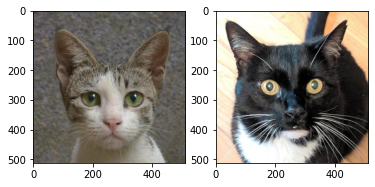

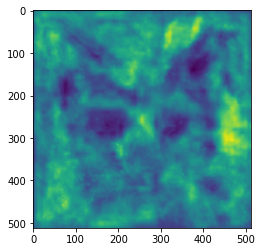

In [ ]:
img_l=left_img[img_index]
img_r=right_img[img_index]
plt.subplot(1,2,1)
plt.imshow(img_l)
plt.subplot(1,2,2)
plt.imshow(img_r)
plt.show()
plt.imshow(d.data.cpu().numpy().reshape(512,512))

Image plotting:

The spatial distance data from each layer

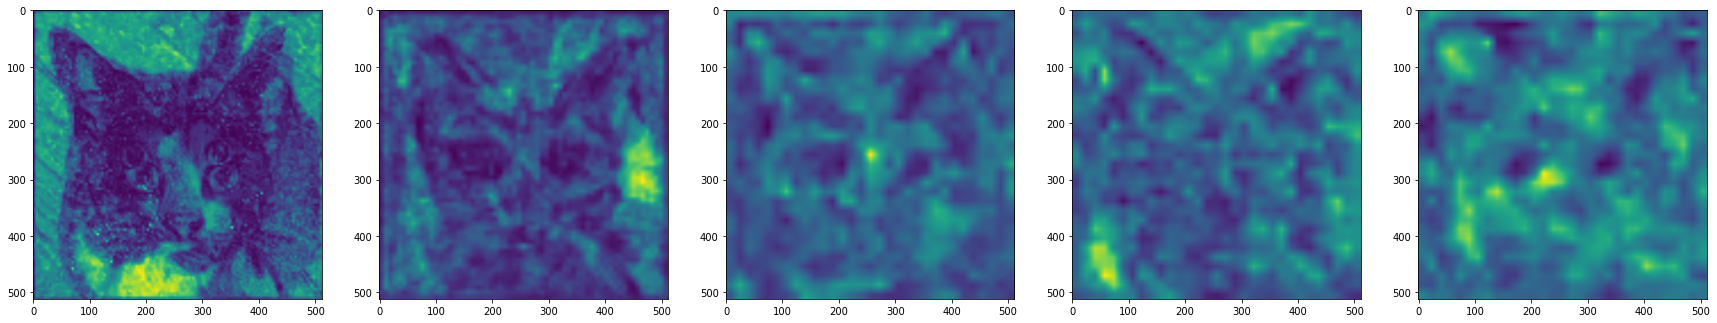

In [ ]:
plt.figure(figsize=(30,30))
for i,data in enumerate(ret):
  plt.subplot(1,5,i+1)
  plt.imshow(data.data.cpu().numpy().reshape(512,512))
plt.show()

To deal the memory shortage, I extracts the average spatial distance data and the spatial distance data from each layer from LPIPS and store those data to Google drive each 100 steps. Afterward, I import the both data indivitually with all steps and merges them into one single file.

In [ ]:
start=0
step=100
for i in range(start,len(target),step):
  d_vgg_s=[]
  d_vgg_ret_s=[]
  for img_l,img_r in zip(left_img[i:i+step],right_img[i:i+step]):
      img_l, img_r=np.array([img_l[:,:,0],img_l[:,:,1],img_l[:,:,2]]).reshape(1,3,512,512),np.array([img_r[:,:,0],img_r[:,:,1],img_r[:,:,2]]).reshape(1,3,512,512)# reshape the image matrix
      img_l, img_r=(img_l - np.min(img_l)) / (np.max(img_l) - np.min(img_l)),(img_r - np.min(img_r)) / (np.max(img_r) - np.min(img_r)) # normalized image
      img1=torch.from_numpy(img_l).float()
      img2=torch.from_numpy(img_r).float()
      d, ret=loss_fn_vgg(img1,img2,retPerLayer=True, normalize=True) 
      #retPerLayer=True means getting each value from the layers of LPIPS, normalize=True means trun input from [0,1] scale into [-1,1] scale
      d_vgg_s.append(d)
      d_vgg_ret_s.append(ret)
  if i == 1200:
    np.save(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s_fully_{i+25}.npy',d_vgg_s)
    np.save(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_s_fully_{i+25}.npy',d_vgg_ret_s)
  else:
    np.save(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s_fully_{i+step}.npy',d_vgg_s)
    np.save(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_s_fully_{i+step}.npy',d_vgg_ret_s)

Data merging function

In [ ]:
step=100
d_vgg_s=[]
d_vgg_ret_s=[]
for i in range(0,len(target),step):
  if i == 1200:
    for data in np.load(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s_fully_{i+25}.npy',allow_pickle=True):
      d_vgg_s.append(data)
    for data in np.load(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_s_fully_{i+25}.npy',allow_pickle=True):
      d_vgg_ret_s.append(data)
  else:
    for data in np.load(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s_fully_{i+step}.npy',allow_pickle=True):
      d_vgg_s.append(data)
    for data in np.load(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_s_fully_{i+step}.npy',allow_pickle=True):
      d_vgg_ret_s.append(data)
d_vgg_s=np.array(d_vgg_s)
d_vgg_ret_s=np.array(d_vgg_ret_s)


In [ ]:
np.save(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s_fully.npy',d_vgg_s)
np.save(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_s_fully.npy',d_vgg_ret_s)